In [1]:
!pip install pandas matplotlib seaborn librosa wordcloud

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import numpy as np
from wordcloud import WordCloud
from google.colab import drive

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [5]:
BASE_PATH = '/content/drive/MyDrive/deep-learning'

In [6]:
MELD_CSV_PATH = os.path.join(BASE_PATH, 'train_sent_emo.csv')
ECAC_JSON_PATH = os.path.join(BASE_PATH, 'Subtask_2_train.json')
AUDIO_FOLDER = os.path.join(BASE_PATH, 'train_splits')

In [7]:
df_text = pd.read_csv(MELD_CSV_PATH)
print(f"Text Data Loaded: {len(df_text)} utterances")

Text Data Loaded: 9989 utterances


In [8]:
with open(ECAC_JSON_PATH, 'r') as f:
    data_cause = json.load(f)
print(f"Cause Data Loaded: {len(data_cause)} conversations")

Cause Data Loaded: 1374 conversations


In [9]:
cause_pairs = []

for conv_data in data_cause:
    if isinstance(conv_data, dict):
        conv_id = conv_data.get('conversation_ID')

        if 'emotion-cause_pairs' in conv_data and isinstance(conv_data['emotion-cause_pairs'], list):
            for pair_str_list in conv_data['emotion-cause_pairs']:
                if len(pair_str_list) == 2:
                    try:

                        emotion_utterance_key = pair_str_list[0]
                        cause_utterance_key = pair_str_list[1]

                        emo_id = int(emotion_utterance_key.split('_')[0].replace('utt', ''))
                        cause_id = int(cause_utterance_key.split('_')[0].replace('utt', ''))

                        emotion_type = 'unknown'
                        if 'conversation' in conv_data and isinstance(conv_data['conversation'], list):
                            for utterance_data in conv_data['conversation']:

                                if utterance_data.get('utterance_ID') == emo_id:
                                    emotion_type = utterance_data.get('emotion', 'unknown')
                                    break

                        pair_data = {
                            'conv_id': conv_id,
                            'emotion_type': emotion_type,
                            'distance': emo_id - cause_id,
                            'emotion_id': emo_id,
                            'cause_id': cause_id
                        }
                        cause_pairs.append(pair_data)
                    except (ValueError, IndexError, KeyError):

                        continue

In [10]:
df_cause = pd.DataFrame(cause_pairs)

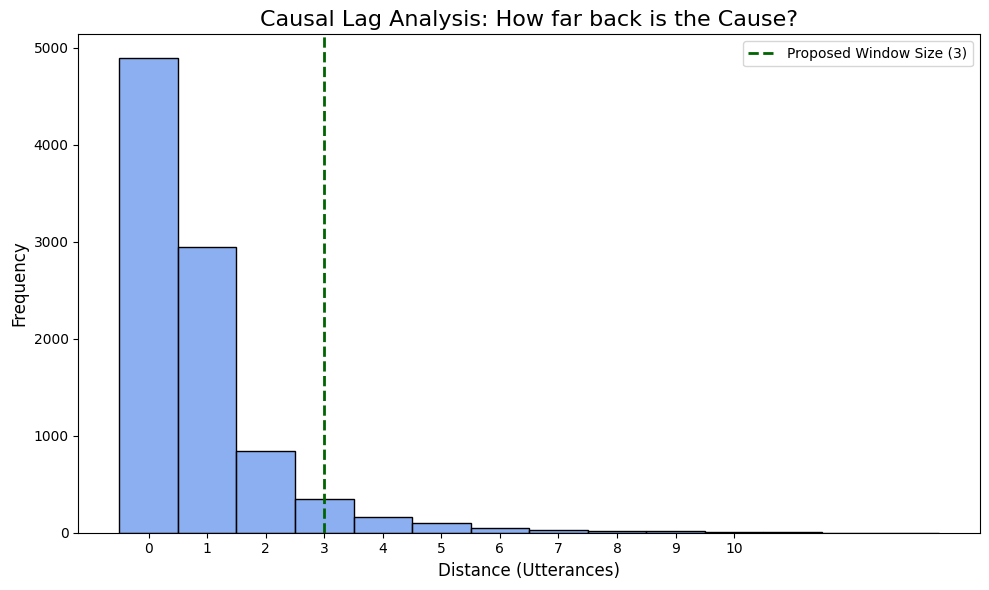

Avg Distance: 0.72 turns


In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(
    df_cause['distance'],
    bins=np.arange(0, 15) - 0.5,
    kde=False,
    color='cornflowerblue',
    edgecolor='black'
)

plt.title('Causal Lag Analysis: How far back is the Cause?', fontsize=16)
plt.xlabel('Distance (Utterances)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(0, 11))
plt.axvline(x=3, color='darkgreen', linestyle='--', linewidth=2,
            label='Proposed Window Size (3)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Avg Distance: {df_cause['distance'].mean():.2f} turns")


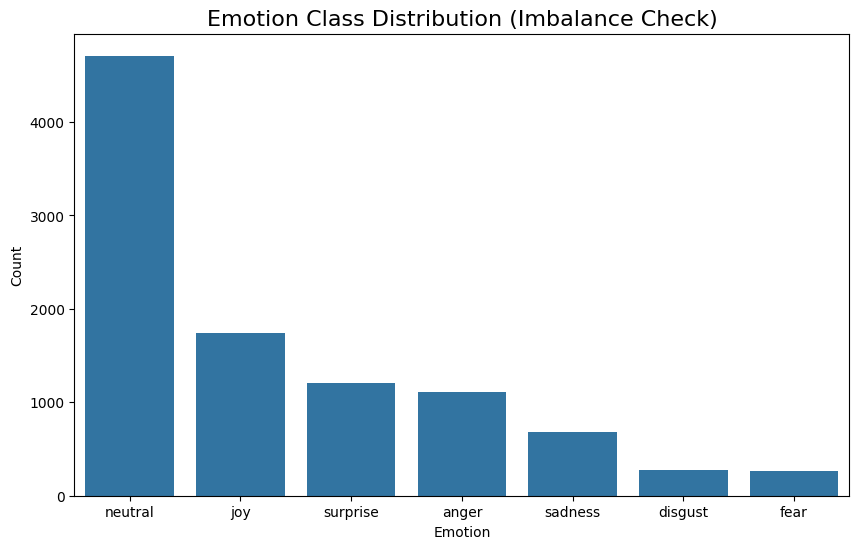

In [12]:
plt.figure(figsize=(10, 6))
order = df_text['Emotion'].value_counts().index
sns.countplot(data=df_text, x='Emotion', order=order)
plt.title('Emotion Class Distribution (Imbalance Check)', fontsize=16)
plt.ylabel('Count')
plt.show()

In [13]:
text_anger = " ".join(df_text[df_text['Emotion'] == 'anger']['Utterance'].astype(str))
wc = WordCloud(width=800, height=400, background_color='white').generate(text_anger)

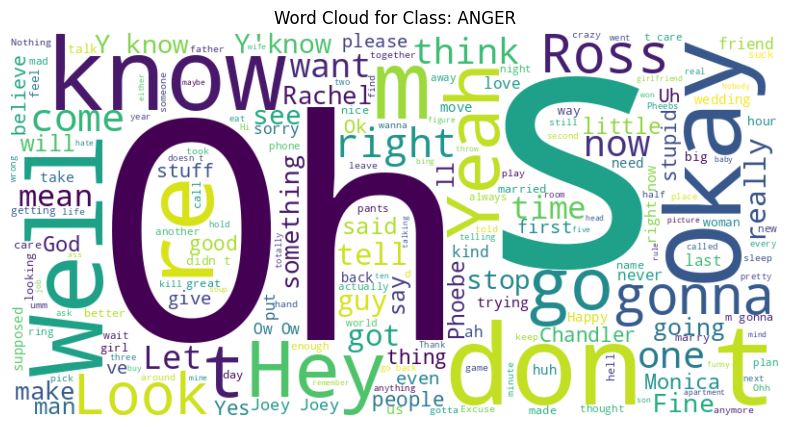

In [14]:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Class: ANGER')
plt.show()

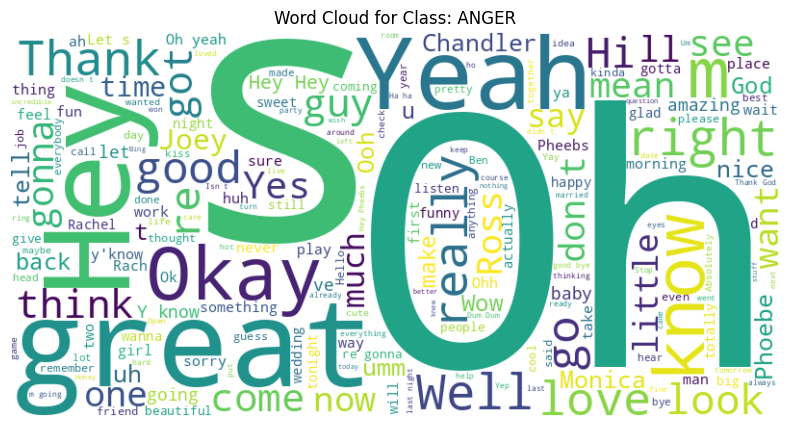

In [15]:
text_joy = " ".join(df_text[df_text['Emotion'] == 'joy']['Utterance'].astype(str))
wc = WordCloud(width=800, height=400, background_color='white').generate(text_joy)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Class: ANGER')
plt.show()

In [16]:
audio_durations = []
missing_files = 0

check_limit = 200
counter = 0

print(f"Checking Audio/Video files in {AUDIO_FOLDER}...")

Checking Audio/Video files in /content/drive/MyDrive/deep-learning/train_splits...


In [17]:

!apt-get install -y ffmpeg

!pip install librosa soundfile --upgrade

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [18]:
for index, row in df_text.iterrows():
    if counter >= check_limit: break

    filename = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.mp4"
    filepath = os.path.join(AUDIO_FOLDER, filename)

    if os.path.exists(filepath):
        try:

            dur = librosa.get_duration(path=filepath)
            audio_durations.append({'Emotion': row['Emotion'], 'Duration': dur})
            counter += 1
        except Exception as e:

            pass
    else:
        missing_files += 1

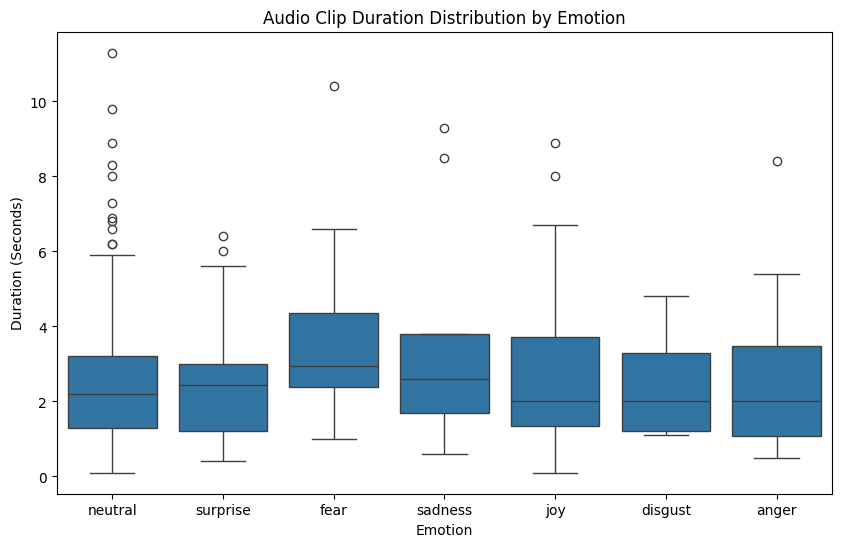

Analyzed 200 audio files.
EDA Complete.


In [19]:
if len(audio_durations) > 0:
    df_audio = pd.DataFrame(audio_durations)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Emotion', y='Duration', data=df_audio)
    plt.title('Audio Clip Duration Distribution by Emotion')
    plt.ylabel('Duration (Seconds)')
    plt.show()

    print(f"Analyzed {len(df_audio)} audio files.")
else:
    print("Skipped Audio Plot: No audio files found in the specified path.")

print(f"EDA Complete.")

/tmp/ipython-input-4155168721.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_text.groupby('Emotion').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)


Analyzing Audio Energy for 350 samples...


100%|██████████| 350/350 [10:41<00:00,  1.83s/it]


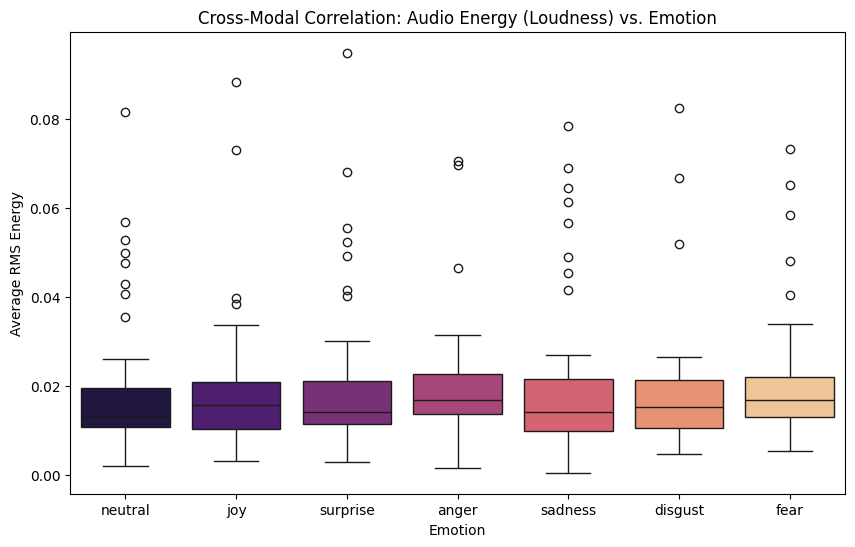


Mean Energy by Emotion (Higher = Louder):
Emotion
fear        0.020928
surprise    0.020330
sadness     0.020208
anger       0.019719
neutral     0.019122
joy         0.018782
disgust     0.018206
Name: Energy_RMS, dtype: float32


In [20]:

import numpy as np
from tqdm import tqdm

sampled_df = df_text.groupby('Emotion').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)

audio_energies = []

print(f"Analyzing Audio Energy for {len(sampled_df)} samples...")

for index, row in tqdm(sampled_df.iterrows(), total=sampled_df.shape[0]):

    filename = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.mp4"
    filepath = os.path.join(AUDIO_FOLDER, filename)

    if os.path.exists(filepath):
        try:

            y, sr = librosa.load(filepath, sr=16000, duration=3.0)

            rms = librosa.feature.rms(y=y)
            avg_energy = np.mean(rms)

            audio_energies.append({
                'Emotion': row['Emotion'],
                'Energy_RMS': avg_energy
            })
        except:
            continue

if len(audio_energies) > 0:
    df_energy = pd.DataFrame(audio_energies)

    plt.figure(figsize=(10, 6))

    sns.boxplot(x='Emotion', y='Energy_RMS', data=df_energy, palette='magma', order=order)
    plt.title('Cross-Modal Correlation: Audio Energy (Loudness) vs. Emotion')
    plt.ylabel('Average RMS Energy')
    plt.show()


    print("\nMean Energy by Emotion (Higher = Louder):")
    print(df_energy.groupby('Emotion')['Energy_RMS'].mean().sort_values(ascending=False))
else:
    print("Could not analyze energy (No audio files found).")

In [21]:
!pip install moviepy transformers librosa torch tqdm


In [22]:
import os
import torch
import librosa
import numpy as np
import pickle
from moviepy.editor import VideoFileClip
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm
from google.colab import drive


BASE_PATH = '/content/drive/MyDrive/deep-learning'


VIDEO_FOLDER = os.path.join(BASE_PATH, 'train_splits')


WAV_FOLDER = os.path.join(BASE_PATH, 'temp_wavs')
os.makedirs(WAV_FOLDER, exist_ok=True)


FEATURE_SAVE_PATH = os.path.join(BASE_PATH, 'audio_features.pkl')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Loading Wav2Vec 2.0 Model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
model.eval()


audio_features_dict = {}
error_files = []


video_files = [f for f in os.listdir(VIDEO_FOLDER) if f.endswith('.mp4')]
print(f"Found {len(video_files)} video files. Starting extraction...")

for video_file in tqdm(video_files):
    video_path = os.path.join(VIDEO_FOLDER, video_file)
    wav_path = os.path.join(WAV_FOLDER, video_file.replace('.mp4', '.wav'))
    file_id = video_file.replace('.mp4', '')

    try:
        if not os.path.exists(wav_path):
            video = VideoFileClip(video_path)

            video.audio.write_audiofile(wav_path, fps=16000, nbytes=2, codec='pcm_s16le', verbose=False, logger=None)
            video.close()


        audio_input, sr = librosa.load(wav_path, sr=16000, duration=6.0)


        input_values = processor(audio_input, sampling_rate=16000, return_tensors="pt", padding="longest").input_values
        input_values = input_values.to(device)

        with torch.no_grad():
            outputs = model(input_values)

        last_hidden_state = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_state, dim=1).squeeze().cpu().numpy()

        audio_features_dict[file_id] = pooled_output

        if os.path.exists(wav_path):
            os.remove(wav_path)

    except Exception as e:
        print(f"Error processing {video_file}: {e}")
        error_files.append(video_file)

print(f"\nExtraction Complete! Processed {len(audio_features_dict)} files.")
print(f"Errors: {len(error_files)}")

print(f"Saving features to {FEATURE_SAVE_PATH}...")
with open(FEATURE_SAVE_PATH, 'wb') as f:
    pickle.dump(audio_features_dict, f)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



Using device: cuda
Loading Wav2Vec 2.0 Model...


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 9988 video files. Starting extraction...


  1%|          | 99/9988 [05:30<9:09:26,  3.33s/it]


KeyboardInterrupt: 

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
import pandas as pd
import pickle
import json
import os
import numpy as np

# ================= CONFIGURATION =================
# Update paths if necessary
BASE_PATH = '/content/drive/MyDrive/deep-learning'
AUDIO_PKL_PATH = os.path.join(BASE_PATH, 'audio_features.pkl')
CSV_PATH = os.path.join(BASE_PATH, 'train_sent_emo.csv')
JSON_PATH = os.path.join(BASE_PATH, 'Subtask_2_train.json')

MAX_LEN = 64  # Max words per sentence for RoBERTa
BATCH_SIZE = 32

# Emotion Mapping (String -> Integer)
EMOTION_MAP = {
    'neutral': 0, 'joy': 1, 'surprise': 2, 'anger': 3,
    'sadness': 4, 'disgust': 5, 'fear': 6
}

# ================= THE DATASET CLASS =================
# class MECPEDataset(Dataset):
#     def __init__(self, csv_path, json_path, audio_pkl_path, tokenizer, max_len):
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#         # 1. Load Data
#         print(f"Loading CSV...")
#         self.df = pd.read_csv(csv_path)

#         print(f"Loading Audio...")
#         with open(audio_pkl_path, 'rb') as f:
#             self.audio_data = pickle.load(f)

#         print(f"Loading JSON...")
#         with open(json_path, 'r') as f:
#             self.cause_data = json.load(f)

#         # 2. MAPPING LOGIC (Based on your JSON snippet)
#         self.cause_map = {}
#         mapped_count = 0

#         print("Parsing Cause Pairs...")

#         for conv in self.cause_data:
#             # Step A: Build a Local Map for this conversation
#             # We map the JSON 'utterance_ID' (e.g., 3) to the Real Key (e.g., "dia0_utt2")
#             local_id_to_key = {}

#             # Check if 'conversation' list exists
#             if 'conversation' in conv:
#                 for utt in conv['conversation']:
#                     try:
#                         u_id = utt['utterance_ID'] # e.g., 3
#                         vid_str = utt['video_name'] # "dia1utt3.mp4"

#                         # PARSE VIDEO NAME TO GET REAL NUMBERS
#                         # "dia1utt3.mp4" -> dia 1, utt 3
#                         # Remove extension
#                         clean = vid_str.replace('.mp4', '')
#                         # Split by 'utt'
#                         parts = clean.split('utt')
#                         dia_num = int(parts[0].replace('dia', '')) # 1
#                         utt_num = int(parts[1]) # 3

#                         # CONVERT TO MELD FORMAT (0-based)
#                         # MELD CSV starts at 0. This JSON starts at 1.
#                         final_dia = dia_num - 1
#                         final_utt = utt_num - 1

#                         # Create the Key our CSV expects: "dia0_utt2"
#                         real_key = f"dia{final_dia}_utt{final_utt}"

#                         # Save mapping: JSON ID 3 -> Real Key "dia0_utt2"
#                         local_id_to_key[u_id] = real_key

#                     except Exception as e:
#                         continue

#             # Step B: Process the Pairs using the Local Map
#             if 'emotion-cause_pairs' in conv:
#                 for pair in conv['emotion-cause_pairs']:
#                     try:
#                         # Pair format: ["3_surprise", "1"]
#                         e_str = pair[0]
#                         c_str = pair[1]

#                         # Extract IDs from strings
#                         e_id_json = int(e_str.split('_')[0]) # 3
#                         c_id_json = int(c_str)             # 1

#                         # Translate JSON IDs to Real Keys using our map
#                         if e_id_json in local_id_to_key and c_id_json in local_id_to_key:
#                             e_real_key = local_id_to_key[e_id_json] # "dia0_utt2"
#                             c_real_key = local_id_to_key[c_id_json] # "dia0_utt0"

#                             # Calculate Distance using the Real Keys
#                             # We need to extract the numbers back out from the key string
#                             e_idx = int(e_real_key.split('_utt')[-1])
#                             c_idx = int(c_real_key.split('_utt')[-1])

#                             dist = e_idx - c_idx

#                             # Valid Window 0 to 5
#                             if 0 <= dist <= 5:
#                                 self.cause_map[e_real_key] = dist
#                                 mapped_count += 1
#                     except:
#                         continue

#         print(f"SUCCESS: Mapped {mapped_count} cause labels.")

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         row = self.df.iloc[index]

#         # CSV Key Construction: "dia0_utt2"
#         unique_id = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}"

#         # Text
#         text = str(row['Utterance'])
#         inputs = self.tokenizer(text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')

#         # Audio
#         if unique_id in self.audio_data:
#             audio_vec = torch.tensor(self.audio_data[unique_id], dtype=torch.float32)
#         else:
#             audio_vec = torch.zeros(768, dtype=torch.float32)

#         # Labels
#         emo_label = EMOTION_MAP.get(row['Emotion'].lower(), 0)

#         # Cause Label (-1 for ignore)
#         cause_label = self.cause_map.get(unique_id, -1)

#         return {
#             'input_ids': inputs['input_ids'].squeeze(0),
#             'attention_mask': inputs['attention_mask'].squeeze(0),
#             'audio_vec': audio_vec,
#             'emotion_label': torch.tensor(emo_label, dtype=torch.long),
#             'cause_label': torch.tensor(cause_label, dtype=torch.long)
#         }

class MECPEDataset(Dataset):
    def __init__(self, csv_path, json_path, audio_pkl_path, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

        # 1. Load Data
        print(f"Loading CSV...")
        self.df = pd.read_csv(csv_path)

        print(f"Loading Audio...")
        with open(audio_pkl_path, 'rb') as f:
            self.audio_data = pickle.load(f)

        print(f"Loading JSON...")
        with open(json_path, 'r') as f:
            self.cause_data = json.load(f)

        self.cause_map = {}
        mapped_count = 0


        min_json_id = float('inf')
        for item in self.cause_data:
            if 'conversation_ID' in item:
                if item['conversation_ID'] < min_json_id:
                    min_json_id = item['conversation_ID']

        # If the CSV starts at 0, we need to subtract this min_id from the JSON IDs
        print(f"Detected JSON Start ID: {min_json_id}. Applying Offset...")

        for item in self.cause_data:
            try:
                # Get the JSON ID
                c_id_json = item['conversation_ID']

                c_id_csv = c_id_json - min_json_id


                utt_offset_map = {}

                if 'conversation' in item:
                    for utt in item['conversation']:
                        u_id = utt['utterance_ID']

                        utt_offset_map[u_id] = u_id - 1

                if 'emotion-cause_pairs' in item:
                    for pair in item['emotion-cause_pairs']:
                        # pair: ["1_disgust", "1"]
                        e_raw_str = pair[0]
                        c_raw_int = int(pair[1])

                        e_raw_int = int(e_raw_str.split('_')[0])

                        # Apply Utterance Offset (1 -> 0)
                        e_idx = utt_offset_map.get(e_raw_int, e_raw_int - 1)
                        c_idx = utt_offset_map.get(c_raw_int, c_raw_int - 1)

                        dist = e_idx - c_idx

                        # Construct Key: "dia0_utt0"
                        key = f"dia{c_id_csv}_utt{e_idx}"

                        if 0 <= dist <= 5:
                            self.cause_map[key] = dist
                            mapped_count += 1
            except:
                continue

        print(f"SUCCESS: Mapped {mapped_count} cause labels after offset correction.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        unique_id = f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}"

        text = str(row['Utterance'])
        inputs = self.tokenizer(text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')

        if unique_id in self.audio_data:
            audio_vec = torch.tensor(self.audio_data[unique_id], dtype=torch.float32)
        else:
            audio_vec = torch.zeros(768, dtype=torch.float32)

        emo_label = EMOTION_MAP.get(row['Emotion'].lower(), 0)
        cause_label = self.cause_map.get(unique_id, -1)

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'audio_vec': audio_vec,
            'emotion_label': torch.tensor(emo_label, dtype=torch.long),
            'cause_label': torch.tensor(cause_label, dtype=torch.long)
        }

print("Initializing Tokenizer...")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

print("Creating Dataset...")
dataset = MECPEDataset(CSV_PATH, JSON_PATH, AUDIO_PKL_PATH, tokenizer, MAX_LEN)

loader = DataLoader(dataset, batch_size=4, shuffle=True)

sample_batch = next(iter(loader))
print("\n=== DATASET CHECK PASSED ===")
print(f"Text Input Shape: {sample_batch['input_ids'].shape} (Should be [4, 64])")
print(f"Audio Input Shape: {sample_batch['audio_vec'].shape} (Should be [4, 768])")
print(f"Emotion Labels: {sample_batch['emotion_label']}")
print(f"Cause Labels (Distance): {sample_batch['cause_label']}")

Initializing Tokenizer...
Creating Dataset...
Loading CSV...
Loading Audio...
Loading JSON...
Detected JSON Start ID: 1. Applying Offset...
SUCCESS: Mapped 9299 cause labels after offset correction.

=== DATASET CHECK PASSED ===
Text Input Shape: torch.Size([4, 64]) (Should be [4, 64])
Audio Input Shape: torch.Size([4, 768]) (Should be [4, 768])
Emotion Labels: tensor([0, 3, 3, 1])
Cause Labels (Distance): tensor([-1, -1,  0, -1])


In [25]:
import torch
import torch.nn as nn
from transformers import RobertaModel

class DualStreamMECPE(nn.Module):
    def __init__(self, num_emotions=7, window_size=6):
        super(DualStreamMECPE, self).__init__()

        # 1. TEXT ENCODER (RoBERTa)
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        layers_to_freeze = list(self.roberta.encoder.layer)[:6]
        for layer in layers_to_freeze:
            for param in layer.parameters():
                param.requires_grad = False
        # -------------------

        # 2. AUDIO ENCODER (Project Wav2Vec 768 -> 768)
        self.audio_fc = nn.Sequential(
            nn.Linear(768, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # 3. CROSS-MODAL ATTENTION FUSION

        self.cross_attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.layer_norm = nn.LayerNorm(768)

        # 4. SHARED CONTEXT LAYER (Bi-Directional LSTM)
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=1,
                            batch_first=True, bidirectional=True)

        # 5. OUTPUT HEADS

        self.emotion_classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_emotions)
        )

        self.cause_classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, window_size)
        )

    def forward(self, input_ids, attention_mask, audio_vec):
        # A. TEXT STREAM
        text_out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_seq = text_out.last_hidden_state

        # B. AUDIO STREAM
        audio_emb = self.audio_fc(audio_vec).unsqueeze(1)

        # C. FUSION (Attention)
        attn_out, _ = self.cross_attention(query=text_seq, key=audio_emb, value=audio_emb)

        # Residual Connection + Norm
        fused_seq = self.layer_norm(text_seq + attn_out)

        # D. POOLING (Get one vector for the whole sentence)
        pooled_features = fused_seq[:, 0, :].unsqueeze(1)

        # E. CONTEXT (LSTM)
        lstm_out, _ = self.lstm(pooled_features)
        final_feat = lstm_out[:, -1, :]

        # F. PREDICT
        emotion_logits = self.emotion_classifier(final_feat)
        cause_logits = self.cause_classifier(final_feat)

        return emotion_logits, cause_logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualStreamMECPE().to(device)
print("Model Architecture Created Successfully!")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Architecture Created Successfully!


In [26]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
from collections import Counter
import torch

# ================= CONFIGURATION =================
EPOCHS = 10
LEARNING_RATE = 2e-5
BATCH_SIZE = 32

# 1. CALCULATE CLASS WEIGHTS (To fix imbalance between Lag 0 and Lag 3)
print("Calculating Class Weights...")
all_causes = []
# Scan dataset to count classes
for i in range(len(dataset)):
    c = dataset[i]['cause_label'].item()
    if c != -1:
        all_causes.append(c)

counts = Counter(all_causes)
total_valid = sum(counts.values())
num_classes = 6 # 0 to 5

class_weights = []
for i in range(num_classes):
    count = counts.get(i, 0)
    # Inverse frequency weighting
    if count > 0:
        weight = total_valid / (num_classes * count)
    else:
        weight = 1.0
    class_weights.append(weight)

# Weights to Tensor
weights_tensor = torch.tensor(class_weights).float().to(device)
print(f"Weights: {class_weights}")

# 2. SETUP LOADER & LOSS
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion_emo = nn.CrossEntropyLoss()
# Apply Weights + Ignore -1
criterion_cause = nn.CrossEntropyLoss(weight=weights_tensor, ignore_index=-1)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

print(f"Starting Final Training on {device}...")

# ================= TRAINING LOOP =================
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    correct_emo = 0
    total_emo = 0

    correct_cause = 0
    total_cause = 0

    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        # Move to GPU
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        audio_vec = batch['audio_vec'].to(device)
        label_emo = batch['emotion_label'].to(device)
        label_cause = batch['cause_label'].to(device)

        # Forward
        out_emo, out_cause = model(input_ids, mask, audio_vec)

        # Loss
        loss_e = criterion_emo(out_emo, label_emo)
        loss_c = criterion_cause(out_cause, label_cause)

        # If batch has no valid causes, ignore cause loss
        if torch.isnan(loss_c):
            loss = loss_e
        else:
            loss = (0.7 * loss_e) + (0.3 * loss_c)

        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy Tracking
        _, pred_e = torch.max(out_emo, 1)
        _, pred_c = torch.max(out_cause, 1)

        correct_emo += (pred_e == label_emo).sum().item()
        total_emo += label_emo.size(0)

        # Cause Accuracy (Valid Only)
        valid_mask = label_cause != -1
        if valid_mask.sum() > 0:
            correct_cause += (pred_c[valid_mask] == label_cause[valid_mask]).sum().item()
            total_cause += valid_mask.sum().item()

        loop.set_description(f"Epoch {epoch+1}/{EPOCHS}")
        loop.set_postfix(loss=loss.item())

    # Stats
    avg_loss = total_loss / len(train_loader)
    acc_emo = correct_emo / total_emo
    acc_cause = correct_cause / total_cause if total_cause > 0 else 0

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Avg Loss: {avg_loss:.4f}")
    print(f"  Emotion Accuracy: {acc_emo*100:.2f}%")
    print(f"  Cause Accuracy: {acc_cause*100:.2f}%")
    print("-" * 30)

print("TRAINING COMPLETE.")
torch.save(model.state_dict(), os.path.join(BASE_PATH, 'final_model.pth'))

Calculating Class Weights...
Weights: [0.22903629536921152, 0.7310252996005326, 6.535714285714286, 16.636363636363637, 34.3125, 42.23076923076923]
Starting Final Training on cuda...


Epoch 1/10: 100%|██████████| 313/313 [01:37<00:00,  3.20it/s, loss=1.25]



Epoch 1 Summary:
  Avg Loss: 1.5493
  Emotion Accuracy: 49.45%
  Cause Accuracy: 60.20%
------------------------------


Epoch 2/10: 100%|██████████| 313/313 [01:35<00:00,  3.29it/s, loss=0.604]



Epoch 2 Summary:
  Avg Loss: 1.2746
  Emotion Accuracy: 62.98%
  Cause Accuracy: 59.78%
------------------------------


Epoch 3/10: 100%|██████████| 313/313 [01:35<00:00,  3.29it/s, loss=1.16]



Epoch 3 Summary:
  Avg Loss: 1.1967
  Emotion Accuracy: 65.89%
  Cause Accuracy: 57.71%
------------------------------


Epoch 4/10: 100%|██████████| 313/313 [01:34<00:00,  3.30it/s, loss=0.699]



Epoch 4 Summary:
  Avg Loss: 1.1316
  Emotion Accuracy: 67.86%
  Cause Accuracy: 59.23%
------------------------------


Epoch 5/10: 100%|██████████| 313/313 [01:34<00:00,  3.30it/s, loss=1.97]



Epoch 5 Summary:
  Avg Loss: 1.0632
  Emotion Accuracy: 70.46%
  Cause Accuracy: 59.08%
------------------------------


Epoch 6/10: 100%|██████████| 313/313 [01:34<00:00,  3.30it/s, loss=0.872]



Epoch 6 Summary:
  Avg Loss: 0.9864
  Emotion Accuracy: 73.14%
  Cause Accuracy: 55.62%
------------------------------


Epoch 7/10: 100%|██████████| 313/313 [01:34<00:00,  3.30it/s, loss=0.693]



Epoch 7 Summary:
  Avg Loss: 0.9030
  Emotion Accuracy: 76.18%
  Cause Accuracy: 59.26%
------------------------------


Epoch 8/10: 100%|██████████| 313/313 [01:34<00:00,  3.30it/s, loss=0.912]



Epoch 8 Summary:
  Avg Loss: 0.8207
  Emotion Accuracy: 78.52%
  Cause Accuracy: 54.07%
------------------------------


Epoch 9/10: 100%|██████████| 313/313 [01:34<00:00,  3.31it/s, loss=0.479]



Epoch 9 Summary:
  Avg Loss: 0.7530
  Emotion Accuracy: 80.32%
  Cause Accuracy: 55.31%
------------------------------


Epoch 10/10: 100%|██████████| 313/313 [01:34<00:00,  3.30it/s, loss=0.0646]



Epoch 10 Summary:
  Avg Loss: 0.6763
  Emotion Accuracy: 82.26%
  Cause Accuracy: 58.68%
------------------------------
TRAINING COMPLETE.


Generating Full Metrics for (Training Set)...


100%|██████████| 313/313 [00:44<00:00,  7.01it/s]



1. EMOTION RECOGNITION (Training Set)
              precision    recall  f1-score   support

     neutral       0.96      0.95      0.96      4710
         joy       0.88      0.89      0.88      1743
    surprise       0.81      0.94      0.87      1205
       anger       0.84      0.85      0.85      1109
     sadness       0.73      0.83      0.78       683
     disgust       0.78      0.42      0.55       271
        fear       0.63      0.32      0.42       268

    accuracy                           0.89      9989
   macro avg       0.81      0.74      0.76      9989
weighted avg       0.89      0.89      0.88      9989



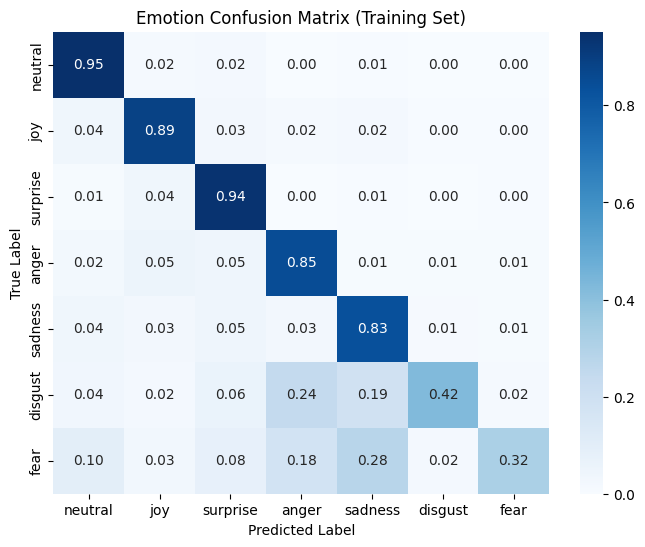

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# ================= CONFIGURATION =================
TARGET_LOADER = train_loader  # We are evaluating the TRAINING set now
TITLE_SUFFIX = "(Training Set)"

# ================= EXECUTION =================
model.eval()
all_preds_emo = []
all_labels_emo = []
all_preds_cause = []
all_labels_cause = []

print(f"Generating Full Metrics for {TITLE_SUFFIX}...")

with torch.no_grad():
    for batch in tqdm(TARGET_LOADER):
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        # Force float to prevent errors
        audio_vec = batch['audio_vec'].to(device).float()

        label_emo = batch['emotion_label'].to(device)
        label_cause = batch['cause_label'].to(device)

        # Forward Pass
        out_emo, out_cause = model(input_ids, mask, audio_vec)

        _, pred_e = torch.max(out_emo, 1)
        _, pred_c = torch.max(out_cause, 1)

        # Store Emotion Results (All samples)
        all_preds_emo.extend(pred_e.cpu().numpy())
        all_labels_emo.extend(label_emo.cpu().numpy())

        # Store Cause Results (Only Valid Ones)
        valid_mask = label_cause != -1
        if valid_mask.sum() > 0:
            all_preds_cause.extend(pred_c[valid_mask].cpu().numpy())
            all_labels_cause.extend(label_cause[valid_mask].cpu().numpy())

# ================= REPORT 1: EMOTION =================
print("\n" + "="*40)
print(f"1. EMOTION RECOGNITION {TITLE_SUFFIX}")
print("="*40)

# Classification Report
emotion_names = list(EMOTION_MAP.keys())
print(classification_report(all_labels_emo, all_preds_emo, target_names=emotion_names))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_emo = confusion_matrix(all_labels_emo, all_preds_emo)
# Normalize
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm_emo = cm_emo.astype('float') / cm_emo.sum(axis=1)[:, np.newaxis]
cm_norm_emo = np.nan_to_num(cm_norm_emo)

sns.heatmap(cm_norm_emo, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title(f'Emotion Confusion Matrix {TITLE_SUFFIX}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



2. CAUSAL SPAN EXTRACTION (Training Set)
              precision    recall  f1-score   support

       Lag 0       0.83      0.67      0.74      2397
       Lag 1       0.39      0.54      0.45       751
       Lag 2       0.48      0.87      0.62        84
       Lag 3       0.25      1.00      0.40        33
       Lag 4       1.00      0.50      0.67        16
       Lag 5       0.73      0.85      0.79        13

    accuracy                           0.65      3294
   macro avg       0.61      0.74      0.61      3294
weighted avg       0.71      0.65      0.67      3294



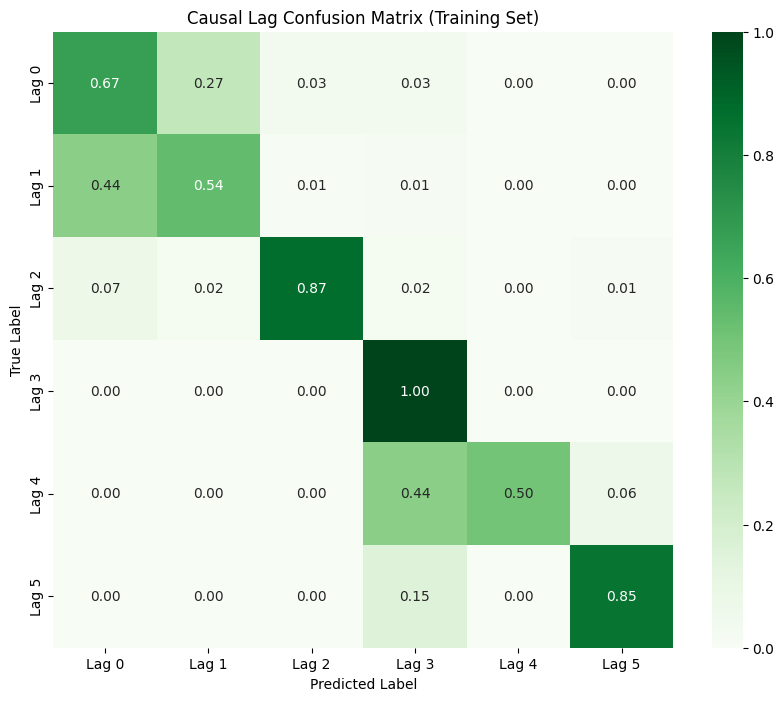

In [34]:
# ================= REPORT 2: CAUSE =================
print("\n" + "="*40)
print(f"2. CAUSAL SPAN EXTRACTION {TITLE_SUFFIX}")
print("="*40)

if len(all_labels_cause) > 0:
    # Get dynamic labels (Lag 0, Lag 1...)
    unique_labels = sorted(list(set(all_labels_cause)))
    target_names = [f"Lag {i}" for i in unique_labels]

    # Classification Report
    print(classification_report(all_labels_cause, all_preds_cause,
                                labels=unique_labels, target_names=target_names))

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm_cause = confusion_matrix(all_labels_cause, all_preds_cause)

    # Normalize
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm_cause = cm_cause.astype('float') / cm_cause.sum(axis=1)[:, np.newaxis]
    cm_norm_cause = np.nan_to_num(cm_norm_cause)

    sns.heatmap(cm_norm_cause, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Causal Lag Confusion Matrix {TITLE_SUFFIX}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
else:
    print("❌ No valid cause labels found.")

In [ ]:
import os
import torch
import librosa
import numpy as np
import pickle
from moviepy.editor import VideoFileClip
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm
from google.colab import drive


BASE_PATH = '/content/drive/MyDrive/deep-learning'

# Input: Where your MP4 videos are
VIDEO_FOLDER = os.path.join(BASE_PATH, 'test_splits')

# Output 1: Temporary folder for WAV files (we delete these later to save space)
WAV_FOLDER = os.path.join(BASE_PATH, 'temp_wavs')
os.makedirs(WAV_FOLDER, exist_ok=True)

# Output 2: The Final Feature File (The one you need for training)
FEATURE_SAVE_PATH = os.path.join(BASE_PATH, 'audio_test.pkl')

# Device: Use GPU if available (Much faster!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# STEP 2: LOAD WAV2VEC MODEL
# ==========================================
print("Loading Wav2Vec 2.0 Model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
model.eval() # Set to evaluation mode (no training)

# ==========================================
# STEP 3: THE EXTRACTION LOOP
# ==========================================
audio_features_dict = {}
error_files = []

# Get list of MP4s
video_files = [f for f in os.listdir(VIDEO_FOLDER) if f.endswith('.mp4')]
print(f"Found {len(video_files)} video files. Starting extraction...")

for video_file in tqdm(video_files):
    video_path = os.path.join(VIDEO_FOLDER, video_file)
    wav_path = os.path.join(WAV_FOLDER, video_file.replace('.mp4', '.wav'))
    file_id = video_file.replace('.mp4', '') # e.g., "dia0_utt0"

    try:
        # A. CONVERT MP4 -> WAV
        # We only do this if the wav doesn't exist yet (in case you restart the script)
        if not os.path.exists(wav_path):
            video = VideoFileClip(video_path)
            # Write audio: 16kHz (Standard for Wav2Vec), Mono (1 channel)
            video.audio.write_audiofile(wav_path, fps=16000, nbytes=2, codec='pcm_s16le', verbose=False, logger=None)
            video.close() # Close to free memory

        # B. LOAD WAV & PREPROCESS
        # Load exactly 6 seconds. If shorter, it pads. If longer, it truncates.
        # This keeps all vectors relatively consistent.
        audio_input, sr = librosa.load(wav_path, sr=16000, duration=6.0)

        # C. EXTRACT FEATURES
        # Tokenize (Convert to Tensor)
        input_values = processor(audio_input, sampling_rate=16000, return_tensors="pt", padding="longest").input_values
        input_values = input_values.to(device)

        # Pass through Model
        with torch.no_grad():
            outputs = model(input_values)

        # D. MEAN POOLING (Crucial Step!)
        # Wav2Vec outputs [Batch, Time, 768]. We want [768] (One vector per file).
        # We average across the Time dimension.
        last_hidden_state = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_state, dim=1).squeeze().cpu().numpy()

        # Save to dictionary
        audio_features_dict[file_id] = pooled_output

        # Clean up: Delete the temp WAV file to save Drive space
        if os.path.exists(wav_path):
            os.remove(wav_path)

    except Exception as e:
        # If a file is corrupted, skip it and log error
        # print(f"Error processing {video_file}: {e}")
        error_files.append(video_file)

# ==========================================
# STEP 4: SAVE EVERYTHING
# ==========================================
print(f"\nExtraction Complete! Processed {len(audio_features_dict)} files.")
print(f"Errors: {len(error_files)}")

print(f"Saving features to {FEATURE_SAVE_PATH}...")
with open(FEATURE_SAVE_PATH, 'wb') as f:
    pickle.dump(audio_features_dict, f)

### Model Evaluation on Test Set


✅ All files found. Running on cuda...
Initializing Test Dataset...
Loading CSV...
Loading Audio...
Loading JSON...
Detected JSON Start ID: 1375. Applying Offset...
SUCCESS: Mapped 2337 cause labels after offset correction.
Loading model weights...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running Inference...


Testing:   0%|          | 0/82 [00:00<?, ?it/s]


 📊 FINAL EVALUATION REPORT 

🔹 EMOTION RECOGNITION (Accuracy: 58.66%)
              precision    recall  f1-score   support

     neutral       0.76      0.71      0.73      1256
         joy       0.49      0.60      0.54       402
    surprise       0.44      0.68      0.53       281
       anger       0.45      0.41      0.43       345
     sadness       0.34      0.28      0.31       208
     disgust       0.50      0.09      0.15        68
        fear       0.50      0.02      0.04        50

    accuracy                           0.59      2610
   macro avg       0.50      0.40      0.39      2610
weighted avg       0.60      0.59      0.58      2610



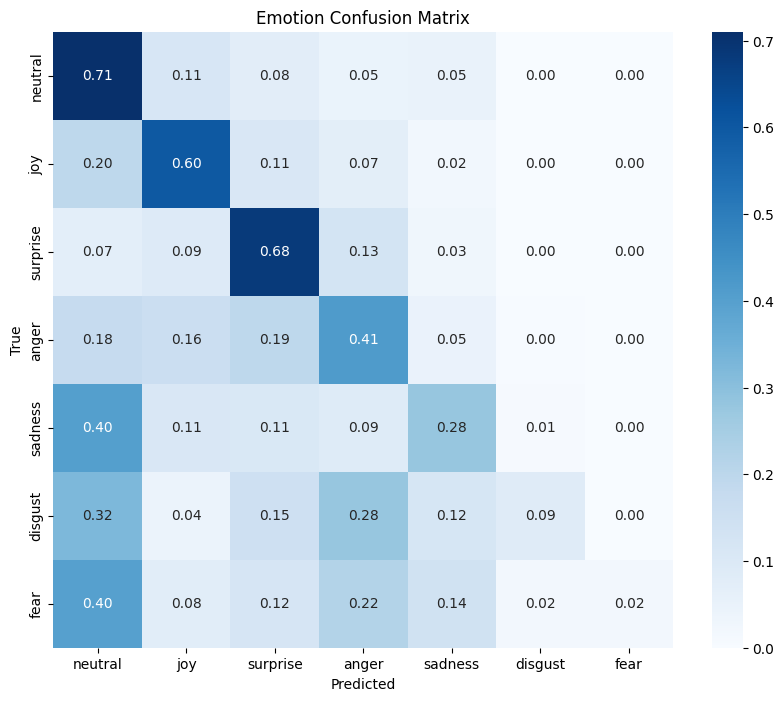

In [35]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
class Config:
    BASE_PATH = '/content/drive/MyDrive/deep-learning'
    TEST_CSV = os.path.join(BASE_PATH, 'test_sent_emo.csv')
    TEST_JSON = os.path.join(BASE_PATH, 'Subtask_2_test.json')
    TEST_AUDIO = os.path.join(BASE_PATH, 'audio_test.pkl') # Ensure this matches your file name
    MODEL_PATH = os.path.join(BASE_PATH, 'final_model.pth')
    BATCH_SIZE = 32
    MAX_LEN = 64
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def check_paths():
    """Verifies all files exist before running."""
    paths = [Config.TEST_CSV, Config.TEST_JSON, Config.TEST_AUDIO, Config.MODEL_PATH]
    for p in paths:
        if not os.path.exists(p):
            raise FileNotFoundError(f"❌ Critical file missing: {p}")
    print(f"✅ All files found. Running on {Config.DEVICE}...")

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def load_model(model_class, path, device):
    """Loads model weights safely handling CPU/GPU mismatch."""
    print("Loading model weights...")
    model = model_class()
    # Auto-map location handles the GPU->CPU crash automatically
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

def plot_cm(y_true, y_pred, title, labels):
    """Plots a beautiful normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    # Normalize with safety check for division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# ==========================================
# 3. MAIN EVALUATION LOOP
# ==========================================
def run_evaluation():
    check_paths()

    # --- LOAD DATA ---
    print("Initializing Test Dataset...")
    # Assuming tokenizer and MECPEDataset are defined in your environment
    test_ds = MECPEDataset(Config.TEST_CSV, Config.TEST_JSON, Config.TEST_AUDIO, tokenizer, Config.MAX_LEN)
    test_loader = DataLoader(test_ds, batch_size=Config.BATCH_SIZE, shuffle=False)

    # --- LOAD MODEL ---
    model = load_model(DualStreamMECPE, Config.MODEL_PATH, Config.DEVICE)

    # --- STORAGE ---
    results = {
        "emo_true": [], "emo_pred": [],
        "cause_true": [], "cause_pred": []
    }

    print("Running Inference...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Move inputs to device
            input_ids = batch['input_ids'].to(Config.DEVICE)
            mask = batch['attention_mask'].to(Config.DEVICE)
            audio_vec = batch['audio_vec'].to(Config.DEVICE).float()

            # Ground Truth
            lbl_emo = batch['emotion_label'].to(Config.DEVICE)
            lbl_cause = batch['cause_label'].to(Config.DEVICE)

            # Inference
            out_emo, out_cause = model(input_ids, mask, audio_vec)

            # Get Predictions
            _, pred_emo = torch.max(out_emo, 1)
            _, pred_cause = torch.max(out_cause, 1)

            # Store Emotion Data
            results["emo_true"].extend(lbl_emo.cpu().numpy())
            results["emo_pred"].extend(pred_emo.cpu().numpy())

            # Store Cause Data (Filter out -1 ignore index)
            valid_mask = lbl_cause != -1
            if valid_mask.sum() > 0:
                results["cause_true"].extend(lbl_cause[valid_mask].cpu().numpy())
                results["cause_pred"].extend(pred_cause[valid_mask].cpu().numpy())

    return results

# ==========================================
# 4. EXECUTION & REPORTING
# ==========================================
# Run the pipeline
results = run_evaluation()

print("\n" + "="*50)
print(" 📊 FINAL EVALUATION REPORT ")
print("="*50)

# --- PART A: EMOTION RESULTS ---
print(f"\n🔹 EMOTION RECOGNITION (Accuracy: {accuracy_score(results['emo_true'], results['emo_pred']):.2%})")
emo_labels = list(EMOTION_MAP.keys()) # Ensure EMOTION_MAP is defined
print(classification_report(results['emo_true'], results['emo_pred'], target_names=emo_labels))
plot_cm(results['emo_true'], results['emo_pred'], "Emotion Confusion Matrix", emo_labels)


🔹 CAUSAL SPAN EXTRACTION (Accuracy: 51.24%)
              precision    recall  f1-score     support
Lag 0          0.712446  0.590747  0.645914  281.000000
Lag 1          0.250000  0.397959  0.307087   98.000000
Lag 2          0.200000  0.083333  0.117647   12.000000
Lag 3          0.125000  0.125000  0.125000    8.000000
Lag 4          0.000000  0.000000  0.000000    4.000000
Lag 5          0.000000  0.000000  0.000000    1.000000
accuracy       0.512376  0.512376  0.512376    0.512376
macro avg      0.214574  0.199507  0.199275  404.000000
weighted avg   0.564598  0.512376  0.529723  404.000000


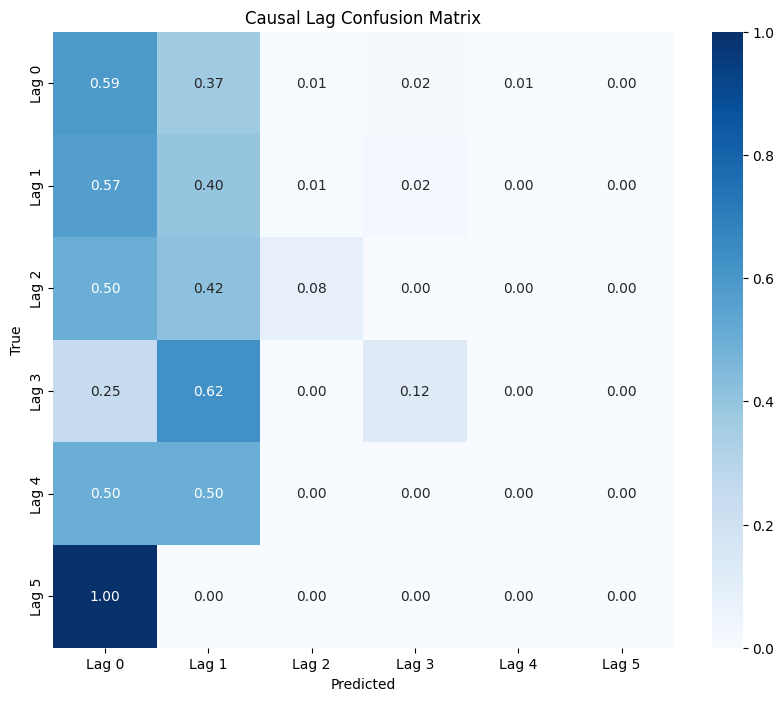

In [36]:
# --- PART B: CAUSE RESULTS ---
if len(results['cause_true']) > 0:
    acc = accuracy_score(results['cause_true'], results['cause_pred'])
    print(f"\n🔹 CAUSAL SPAN EXTRACTION (Accuracy: {acc:.2%})")

    # Dynamic Label Generation (Lag 0, Lag 1...)
    unique_labels = sorted(list(set(results['cause_true'])))
    cause_names = [f"Lag {i}" for i in unique_labels]

    # Pandas Report for cleaner view
    report_dict = classification_report(results['cause_true'], results['cause_pred'],
                                        labels=unique_labels, target_names=cause_names, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    print(df_report) # Prints a nice table

    # Plot
    plot_cm(results['cause_true'], results['cause_pred'], "Causal Lag Confusion Matrix", cause_names)
else:
    print("\n❌ No valid cause labels found in Test Set (Blind Set Detected).")